In [2]:
# Install the torch package
#%pip install torch
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from itertools import product
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from data import merged

# Load Data

In [3]:
# Load the data and drop VADER columns
df_train = pd.read_csv('data/merged/merged_cleaned_sentiment_train.csv').drop(['pos','neg','neu', 'compound'], axis = 1)
df_val = pd.read_csv('data/merged/merged_cleaned_sentiment_validation.csv').drop(['pos','neg','neu', 'compound'], axis = 1)
df_test = pd.read_csv('data/merged/merged_cleaned_sentiment_test.csv').drop(['pos','neg','neu', 'compound'], axis = 1)

In [4]:
#Save audio features
# 5 audio features + 2 real target
df_train = df_train[['danceability', 'energy', 'instrumentalness', 'valence','mode', 'y_valence', 'y_arousal']]
df_val = df_val[['danceability', 'energy', 'instrumentalness', 'valence','mode', 'y_valence', 'y_arousal']]
df_test = df_test[['danceability', 'energy', 'instrumentalness', 'valence','mode','y_valence', 'y_arousal']]


In [5]:
# Remove rows with missing values from the training, validation, and test datasets
df_train = df_train.dropna()
df_val = df_val.dropna()
df_test = df_test.dropna()

In [6]:
# output colums
df_train.columns

Index(['danceability', 'energy', 'instrumentalness', 'valence', 'mode',
       'y_valence', 'y_arousal'],
      dtype='object')

## 分割vali，test，train

In [7]:

# Training set
# X_train: Features for training set, excluding the target variables 'y_valence' and 'y_arousal'
X_train = df_train.drop(['y_valence', 'y_arousal'], axis=1).values
# y_train_valence: Target variable 'y_valence' for training set
y_train_valence = df_train.y_valence.values 
# y_train_arousal: Target variable 'y_arousal' for training set
y_train_arousal = df_train.y_arousal.values
    
# Validation set
# X_val: Features for validation set, excluding the target variables 'y_valence' and 'y_arousal'
X_val = df_val.drop(['y_valence', 'y_arousal'], axis=1).values
# y_val_valence: Target variable 'y_valence' for validation set
y_val_valence = df_val.y_valence.values 
# y_val_arousal: Target variable 'y_arousal' for validation set
y_val_arousal = df_val.y_arousal.values 

# Test set
# X_test: Features for test set, excluding the target variables 'y_valence' and 'y_arousal'
X_test = df_test.drop(['y_valence', 'y_arousal'], axis=1).values
# y_test_valence: Target variable 'y_valence' for test set
y_test_valence = df_test.y_valence.values 
# y_test_arousal: Target variable 'y_arousal' for test set
y_test_arousal = df_test.y_arousal.values

## Normalization

In [12]:
# 第二步：归一化（💡 训练集 fit，val/test 只 transform）
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

## Evaluation

In [6]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(X_val, y_1_validation, y_2_validation, model_predictions_file='predictions.csv'):
    """Evaluate the trained model using different evaluation criteria, including Normalized RMSE"""
    
    # Load the saved predictions from the CSV file
    df_predictions = pd.read_csv(model_predictions_file)
    
    # Get the true values from validation data
    true_valence = y_1_validation
    true_arousal = y_2_validation

    # Ensure predictions are in the original range (if necessary)
    # If predictions are standardized, use the inverse_transform of your scaler before proceeding.
    # Example: df_predictions['pred_valence'] = scaler.inverse_transform(df_predictions[['pred_valence']])

    # Compute RMSE
    rmse_valence = mean_squared_error(true_valence, df_predictions['pred_valence'], squared=False)
    rmse_arousal = mean_squared_error(true_arousal, df_predictions['pred_arousal'], squared=False)

    # Compute Normalized RMSE
    valence_range = max(true_valence) - min(true_valence)
    arousal_range = max(true_arousal) - min(true_arousal)

    normalized_rmse_valence = rmse_valence / valence_range if valence_range > 0 else None
    normalized_rmse_arousal = rmse_arousal / arousal_range if arousal_range > 0 else None

    # Compute R²
    r2_valence = r2_score(true_valence, df_predictions['pred_valence'])
    r2_arousal = r2_score(true_arousal, df_predictions['pred_arousal'])

    # Print evaluation results
    print(f"RMSE for Valence: {rmse_valence:.4f}")
    print(f"RMSE for Arousal: {rmse_arousal:.4f}")
    print(f"Normalized RMSE for Valence: {normalized_rmse_valence:.4f}" if normalized_rmse_valence is not None else "Valence range is zero, cannot compute NRMSE.")
    print(f"Normalized RMSE for Arousal: {normalized_rmse_arousal:.4f}" if normalized_rmse_arousal is not None else "Arousal range is zero, cannot compute NRMSE.")
    print(f"R² for Valence: {r2_valence:.4f}")
    print(f"R² for Arousal: {r2_arousal:.4f}")
    
    # Return evaluation results as a dictionary
    eval_results = {
        'rmse_valence': rmse_valence,
        'rmse_arousal': rmse_arousal,
        'normalized_rmse_valence': normalized_rmse_valence,
        'normalized_rmse_arousal': normalized_rmse_arousal,
        'r2_valence': r2_valence,
        'r2_arousal': r2_arousal
    }

    return eval_results


# Try

Epoch 50, Loss: 1.0246
Epoch 100, Loss: 1.0029
Epoch 150, Loss: 1.0001
Epoch 200, Loss: 0.9997
Epoch 250, Loss: 0.9996
Epoch 300, Loss: 0.9996


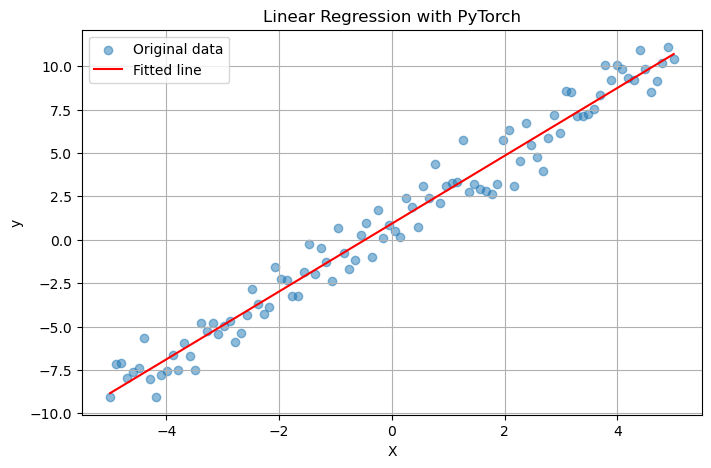


Learned function: y = 1.95x + 0.93


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 1. 生成数据：y = 2x + 1 + 一点点噪声
X = np.linspace(-5, 5, 100)
y = 2 * X + 1 + np.random.normal(0, 1, size=X.shape)  # 加一点噪声

# 转成 tensor
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  # shape (100, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape (100, 1)

# 2. 定义模型：输入1维，输出1维
model = nn.Linear(in_features=1, out_features=1)

# 3. 定义损失函数 和 优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 4. 训练循环
for epoch in range(300):
    model.train()

    pred = model(X_tensor)
    loss = criterion(pred, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# 5. 可视化结果
model.eval()
with torch.no_grad():
    predicted = model(X_tensor).squeeze().numpy()

plt.figure(figsize=(8, 5))
plt.scatter(X, y, label='Original data', alpha=0.5)
plt.plot(X, predicted, color='red', label='Fitted line')
plt.title("Linear Regression with PyTorch")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# 查看学到的参数
w = model.weight.item()
b = model.bias.item()
print(f"\nLearned function: y = {w:.2f}x + {b:.2f}")


# Model LR

In [104]:
def train_single_linear(X_train, y_train, X_val, fit_intercept=True, positive=False, epochs=500, lr=0.01):
    n_samples, n_features = X_train.shape

    # 定义模型
    model = nn.Linear(n_features, 1, bias=fit_intercept)
    
    # 初始化正值约束：将初始权重设为正
    if positive:
        with torch.no_grad():
            model.weight.data = torch.abs(model.weight.data)
            if fit_intercept:
                model.bias.data = torch.abs(model.bias.data)

    # 定义损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)

    # 训练
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(X_tensor).squeeze()
        loss = criterion(pred, y_tensor)
        loss.backward()
        optimizer.step()

        # 正值约束：手动把权重截断为正数
        if positive:
            with torch.no_grad():
                model.weight.data = torch.clamp(model.weight.data, min=0.0)
                if fit_intercept:
                    model.bias.data = torch.clamp(model.bias.data, min=0.0)

    # 用验证集评估
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        pred_val = model(X_val_tensor).squeeze().numpy()
    return model, pred_val

In [105]:
def train_regression_torch(X, y_1, y_2, X_val, param_grid=None):
    if param_grid is None:
        param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}
    
    best_score_val = float('inf')
    best_score_arou = float('inf')
    best_model_val = None
    best_model_arou = None
    best_params_val = {}
    best_params_arou = {}
    


    # 遍历所有参数组合
    for fit_intercept, positive in product(param_grid['fit_intercept'], param_grid['positive']):
        print(f"🔍 Trying fit_intercept={fit_intercept}, positive={positive}...")

        # 训练并验证 Valence 模型
        model_val, pred_val = train_single_linear(X, y_1, X_val, fit_intercept, positive)
        score_val = mean_squared_error(y_1, model_val(torch.tensor(X, dtype=torch.float32)).squeeze().detach().numpy())

        if score_val < best_score_val:
            best_score_val = score_val
            best_model_val = model_val
            

            best_params_val = {'fit_intercept': fit_intercept, 'positive': positive}
            
        
        # 训练并验证 Arousal 模型
        model_arou, pred_arou = train_single_linear(X, y_2, X_val, fit_intercept, positive)
        score_arou = mean_squared_error(y_2, model_arou(torch.tensor(X, dtype=torch.float32)).squeeze().detach().numpy())

        if score_arou < best_score_arou:
            best_score_arou = score_arou
            best_model_arou = model_arou
            best_params_arou = {'fit_intercept': fit_intercept, 'positive': positive}

    print()
    print(f"✅ Best parameters for Valence (Train MSE = {best_score_val:.4f}): {best_params_val}")
    print(f"✅ Best parameters for Arousal (Train MSE = {best_score_arou:.4f}): {best_params_arou}")

    # 最终预测并保存
    best_model_val.eval()
    best_model_arou.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        predictions_val = best_model_val(X_val_tensor).squeeze().numpy()
        predictions_arou = best_model_arou(X_val_tensor).squeeze().numpy()

    df_predictions = pd.DataFrame({
        'pred_valence': predictions_val,
        'pred_arousal': predictions_arou
    })
    df_predictions.to_csv('csv/lr_prediction_torch1.csv', index=False)

    print("🎉 PyTorch 线性回归训练完成并已保存预测！")
    return best_model_val, best_model_arou,best_params_val, best_params_arou

## Train model

In [109]:
# 第三步：调用训练函数（注意传入的是“scaled”的数据）
best_model_val, best_model_arou,best_params_val,best_params_arou= train_regression_torch(
    X_train_scaled, y_train_valence,
    y_train_arousal, X_val_scaled
)

🔍 Trying fit_intercept=True, positive=True...
🔍 Trying fit_intercept=True, positive=False...
🔍 Trying fit_intercept=False, positive=True...
🔍 Trying fit_intercept=False, positive=False...

✅ Best parameters for Valence (Train MSE = 1.0469): {'fit_intercept': True, 'positive': False}
✅ Best parameters for Arousal (Train MSE = 0.8429): {'fit_intercept': True, 'positive': False}
🎉 PyTorch 线性回归训练完成并已保存预测！


In [ ]:
best_model_val, best_model_arou = train_regression_torch(X_train, y_train_valence, y_train_arousal, X_val)


🔍 Trying fit_intercept=True, positive=True...
🔍 Trying fit_intercept=True, positive=False...
🔍 Trying fit_intercept=False, positive=True...
🔍 Trying fit_intercept=False, positive=False...

✅ Best parameters for Valence (Train MSE = 1.0569): {'fit_intercept': True, 'positive': False}
✅ Best parameters for Arousal (Train MSE = 0.8477): {'fit_intercept': True, 'positive': False}
🎉 PyTorch 线性回归训练完成并已保存预测！


## RMSE+R2

In [115]:
results_scaled = evaluate_model(
    X_val=X_val,
    y_1_validation=y_val_valence,
    y_2_validation=y_val_arousal,
    model_predictions_file='csv/lr_prediction_torch1.csv'
)


RMSE for Valence: 0.9857
RMSE for Arousal: 0.8942
Normalized RMSE for Valence: 0.2831
Normalized RMSE for Arousal: 0.1757
R² for Valence: 0.0957
R² for Arousal: 0.1157


## Test

## 新的

In [ ]:
def train_regression_torch(X, y_1, y_2, X_val, param_grid=None):
    if param_grid is None:
        param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}
    
    best_score_val = float('inf')
    best_score_arou = float('inf')
    best_model_val = None
    best_model_arou = None
    best_params_val = {}
    best_params_arou = {}
    


    # 遍历所有参数组合
    for fit_intercept, positive in product(param_grid['fit_intercept'], param_grid['positive']):
        print(f"🔍 Trying fit_intercept={fit_intercept}, positive={positive}...")

        # 训练并验证 Valence 模型
        model_val, pred_val = train_single_linear(X, y_1, X_val, fit_intercept, positive)
        score_val = mean_squared_error(y_1, model_val(torch.tensor(X, dtype=torch.float32)).squeeze().detach().numpy())

        if score_val < best_score_val:
            best_score_val = score_val
            best_model_val = model_val
            

            best_params_val = {'fit_intercept': fit_intercept, 'positive': positive}
            
        
        # 训练并验证 Arousal 模型
        model_arou, pred_arou = train_single_linear(X, y_2, X_val, fit_intercept, positive)
        score_arou = mean_squared_error(y_2, model_arou(torch.tensor(X, dtype=torch.float32)).squeeze().detach().numpy())

        if score_arou < best_score_arou:
            best_score_arou = score_arou
            best_model_arou = model_arou
            best_params_arou = {'fit_intercept': fit_intercept, 'positive': positive}

    print()
    print(f"✅ Best parameters for Valence (Train MSE = {best_score_val:.4f}): {best_params_val}")
    print(f"✅ Best parameters for Arousal (Train MSE = {best_score_arou:.4f}): {best_params_arou}")

    # 最终预测并保存
    best_model_val.eval()
    best_model_arou.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
        predictions_val = best_model_val(X_val_tensor).squeeze().numpy()
        predictions_arou = best_model_arou(X_val_tensor).squeeze().numpy()

    df_predictions = pd.DataFrame({
        'pred_valence': predictions_val,
        'pred_arousal': predictions_arou
    })
    df_predictions.to_csv('csv/lr_prediction_torch1.csv', index=False)

    print("🎉 PyTorch 线性回归训练完成并已保存预测！")
    return best_model_val, best_model_arou

In [110]:
# 假设你训练完了
best_model_val, best_model_arou,best_params_val, best_params_arou= train_regression_torch(X_train, y_train_valence, y_train_arousal, X_val)

# 用训练集重新训练最终模型（PyTorch 版本）
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_val_final, _ = train_single_linear(X_train_scaled, y_train_valence, X_val=X_test_scaled, fit_intercept=best_params_val['fit_intercept'],
    positive=best_params_val['positive'])
model_arou_final, _ = train_single_linear(X_train_scaled, y_train_arousal, X_val=X_test_scaled, fit_intercept=best_params_val['fit_intercept'],
    positive=best_params_val['positive'])
# 测试集预测
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
pred_val = model_val_final(X_test_tensor).detach().numpy().squeeze()
pred_arou = model_arou_final(X_test_tensor).detach().numpy().squeeze()

# 计算评估指标
from sklearn.metrics import mean_squared_error, r2_score

rmse_val = mean_squared_error(y_test_valence, pred_val, squared=False)
rmse_arou = mean_squared_error(y_test_arousal, pred_arou, squared=False)

r2_val = r2_score(y_test_valence, pred_val)
r2_arou = r2_score(y_test_arousal, pred_arou)

# Normalized RMSE
val_range = np.max(y_test_valence) - np.min(y_test_valence)
arou_range = np.max(y_test_arousal) - np.min(y_test_arousal)
nrmse_val = rmse_val / val_range
nrmse_arou = rmse_arou / arou_range

# 打印结果
print("📊 Test Set Evaluation (PyTorch LR)")
print(f"RMSE (Valence): {rmse_val:.4f}")
print(f"RMSE (Arousal): {rmse_arou:.4f}")
print(f"R² (Valence): {r2_val:.4f}")
print(f"R² (Arousal): {r2_arou:.4f}")
print(f"Normalized RMSE (Valence): {nrmse_val:.4f}")
print(f"Normalized RMSE (Arousal): {nrmse_arou:.4f}")


🔍 Trying fit_intercept=True, positive=True...
🔍 Trying fit_intercept=True, positive=False...
🔍 Trying fit_intercept=False, positive=True...
🔍 Trying fit_intercept=False, positive=False...

✅ Best parameters for Valence (Train MSE = 1.0212): {'fit_intercept': True, 'positive': False}
✅ Best parameters for Arousal (Train MSE = 0.8355): {'fit_intercept': True, 'positive': False}
🎉 PyTorch 线性回归训练完成并已保存预测！
📊 Test Set Evaluation (PyTorch LR)
RMSE (Valence): 0.9865
RMSE (Arousal): 0.8976
R² (Valence): 0.1227
R² (Arousal): 0.1111
Normalized RMSE (Valence): 0.2670
Normalized RMSE (Arousal): 0.1764


##旧的

In [112]:
# 1. Normalize the test set
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 2. Model predictions
best_model_val.eval()
best_model_arou.eval()
with torch.no_grad():
    pred_val_test = best_model_val(X_test_tensor).squeeze().numpy()
    pred_arou_test = best_model_arou(X_test_tensor).squeeze().numpy()

# 3. Compute evaluation metrics
rmse_val = mean_squared_error(y_test_valence, pred_val_test, squared=False)
rmse_arou = mean_squared_error(y_test_arousal, pred_arou_test, squared=False)
r2_val = r2_score(y_test_valence, pred_val_test)
r2_arou = r2_score(y_test_arousal, pred_arou_test)

# Compute label ranges (valence and arousal)
valence_range = max(y_test_valence) - min(y_test_valence)
arousal_range = max(y_test_arousal) - min(y_test_arousal)

# Compute Normalized RMSE
nrmse_val = rmse_val / valence_range if valence_range > 0 else None
nrmse_arou = rmse_arou / arousal_range if arousal_range > 0 else None

# 4. Print results
print(f"📊 Test RMSE (Valence): {rmse_val:.4f}")
print(f"📊 Test RMSE (Arousal): {rmse_arou:.4f}")
print(f"📈 Test R² (Valence): {r2_val:.4f}")
print(f"📈 Test R² (Arousal): {r2_arou:.4f}")
print(f"🧮 Normalized RMSE (Valence): {nrmse_val:.4f}")
print(f"🧮 Normalized RMSE (Arousal): {nrmse_arou:.4f}")

📊 Test RMSE (Valence): 0.9881
📊 Test RMSE (Arousal): 0.9017
📈 Test R² (Valence): 0.1199
📈 Test R² (Arousal): 0.1030
🧮 Normalized RMSE (Valence): 0.2674
🧮 Normalized RMSE (Arousal): 0.1772


# Model MLP

## define model

In [5]:
# Define a generic MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for h in hidden_layer_sizes:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

NameError: name 'nn' is not defined

In [4]:
def train_mlp_torch(X, y_1, y_2, X_val, param_grid=None):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_val_scaled = scaler.transform(X_val)

    if param_grid is None:
        param_grid = {
            'hidden_layer_sizes': [(5,), (10,), (15,), (5,5), (10,10), (15,15)],
            'max_iter': [500, 1000]
        }

    best_val_model = None
    best_arou_model = None
    best_val_score = float('inf')
    best_arou_score = float('inf')
    best_hidden_layers = None
    best_max_iter = None

    for hidden_layers, max_iter in product(param_grid['hidden_layer_sizes'], param_grid['max_iter']):
        print(f"🔍 Trying config: hidden_layers={hidden_layers}, max_iter={max_iter}")

        model_val = train_single_mlp(X_scaled, y_1, hidden_layers, max_iter)
        preds_val = model_val(torch.tensor(X_scaled, dtype=torch.float32)).detach().numpy().squeeze()
        mse_val = mean_squared_error(y_1, preds_val)

        if mse_val < best_val_score:
            best_val_score = mse_val
            best_val_model = model_val
            best_hidden_layers = hidden_layers
            best_max_iter = max_iter

        model_arou = train_single_mlp(X_scaled, y_2, hidden_layers, max_iter)
        preds_arou = model_arou(torch.tensor(X_scaled, dtype=torch.float32)).detach().numpy().squeeze()
        mse_arou = mean_squared_error(y_2, preds_arou)

        if mse_arou < best_arou_score:
            best_arou_score = mse_arou
            best_arou_model = model_arou

    # 用最优模型在验证集上预测并保存为 CSV（仅验证集）
    best_val_model.eval()
    best_arou_model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        predictions_val = best_val_model(X_val_tensor).squeeze().numpy()
        predictions_arou = best_arou_model(X_val_tensor).squeeze().numpy()

    df_predictions = pd.DataFrame({
        'pred_valence': predictions_val,
        'pred_arousal': predictions_arou
    })
    df_predictions.to_csv('csv/AUdio_predictions_mlp_torch3.csv', index=False)

    print("✅ PyTorch MLP training completed and validation predictions saved.")
    return best_val_model, best_arou_model, scaler, best_hidden_layers, best_max_iter


In [3]:
# Training function for one model
def train_single_mlp(X_train, y_train, hidden_layers, max_iter):
    model = MLP(X_train.shape[1], hidden_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    model.train()
    for epoch in range(max_iter):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

    return model


In [2]:
def train_mlp_torch(X, y_1, y_2, X_val, param_grid=None):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_val_scaled = scaler.transform(X_val)

    if param_grid is None:
        param_grid = {
            'hidden_layer_sizes': [(5,), (10,), (15,), (5,5), (10,10), (15,15), (5,5,5), (10,10,10), (15,15,15)],
            'max_iter': [500, 1000, 2000, 2500]
        }

    best_val_model = None
    best_arou_model = None
    best_val_score = float('inf')
    best_arou_score = float('inf')

    for hidden_layers, max_iter in product(param_grid['hidden_layer_sizes'], param_grid['max_iter']):
        print(f"🔍 Trying config: hidden_layers={hidden_layers}, max_iter={max_iter}")

        # Train valence model
        model_val = train_single_mlp(X_scaled, y_1, hidden_layers, max_iter)
        preds_val = model_val(torch.tensor(X_scaled, dtype=torch.float32)).detach().numpy().squeeze()
        mse_val = mean_squared_error(y_1, preds_val)
        if mse_val < best_val_score:
            best_val_score = mse_val
            best_val_model = model_val
           

        # Train arousal model
        model_arou = train_single_mlp(X_scaled, y_2, hidden_layers, max_iter)
        preds_arou = model_arou(torch.tensor(X_scaled, dtype=torch.float32)).detach().numpy().squeeze()
        mse_arou = mean_squared_error(y_2, preds_arou)
        if mse_arou < best_arou_score:
            best_arou_score = mse_arou
            best_arou_model = model_arou

    # Predict on validation set
    best_val_model.eval()
    best_arou_model.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        predictions_val = best_val_model(X_val_tensor).squeeze().numpy()
        predictions_arou = best_arou_model(X_val_tensor).squeeze().numpy()

    df_predictions = pd.DataFrame({
        'pred_valence': predictions_val,
        'pred_arousal': predictions_arou
    })
    df_predictions.to_csv('csv/AUdio_predictions_mlp_torch4.csv', index=False)

    print("✅ PyTorch MLP training completed and predictions saved!")
    return best_val_model, best_arou_model, scaler

## Train

In [81]:
best_val_model, best_arou_model, scaler, best_layers, best_iter = train_mlp_torch(
    X_train, y_train_valence, y_train_arousal, X_val
)


🔍 Trying config: hidden_layers=(5,), max_iter=500


KeyboardInterrupt: 

In [7]:
results_scaled = evaluate_model(
    X_val=X_val_scaled,
    y_1_validation=y_val_valence,
    y_2_validation=y_val_arousal,
    model_predictions_file='csv/AUdio_predictions_mlp_torch3.csv'
)

NameError: name 'X_val_scaled' is not defined

## Test

## try

## 新的

In [76]:
# 假设你训练完了
best_val_model, best_arou_model, scaler, best_layers, best_iter = train_mlp_torch(X_train, y_train_valence, y_train_arousal, X_val)

# 用训练集重新训练最终模型（PyTorch 版本）
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model_val_final = train_single_mlp(X_train_scaled, y_train_valence, best_layers, best_iter)
model_arou_final = train_single_mlp(X_train_scaled, y_train_arousal, best_layers, best_iter)

# 测试集预测
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
pred_val = model_val_final(X_test_tensor).detach().numpy().squeeze()
pred_arou = model_arou_final(X_test_tensor).detach().numpy().squeeze()

# 计算评估指标
from sklearn.metrics import mean_squared_error, r2_score

rmse_val = mean_squared_error(y_test_valence, pred_val, squared=False)
rmse_arou = mean_squared_error(y_test_arousal, pred_arou, squared=False)

r2_val = r2_score(y_test_valence, pred_val)
r2_arou = r2_score(y_test_arousal, pred_arou)

# Normalized RMSE
val_range = np.max(y_test_valence) - np.min(y_test_valence)
arou_range = np.max(y_test_arousal) - np.min(y_test_arousal)
nrmse_val = rmse_val / val_range
nrmse_arou = rmse_arou / arou_range

# 打印结果
print("📊 Test Set Evaluation (PyTorch MLP)")
print(f"RMSE (Valence): {rmse_val:.4f}")
print(f"RMSE (Arousal): {rmse_arou:.4f}")
print(f"R² (Valence): {r2_val:.4f}")
print(f"R² (Arousal): {r2_arou:.4f}")
print(f"Normalized RMSE (Valence): {nrmse_val:.4f}")
print(f"Normalized RMSE (Arousal): {nrmse_arou:.4f}")


🔍 Trying config: hidden_layers=(5,), max_iter=500
🔍 Trying config: hidden_layers=(5,), max_iter=1000
🔍 Trying config: hidden_layers=(10,), max_iter=500
🔍 Trying config: hidden_layers=(10,), max_iter=1000
🔍 Trying config: hidden_layers=(15,), max_iter=500
🔍 Trying config: hidden_layers=(15,), max_iter=1000
🔍 Trying config: hidden_layers=(5, 5), max_iter=500
🔍 Trying config: hidden_layers=(5, 5), max_iter=1000
🔍 Trying config: hidden_layers=(10, 10), max_iter=500
🔍 Trying config: hidden_layers=(10, 10), max_iter=1000
🔍 Trying config: hidden_layers=(15, 15), max_iter=500
🔍 Trying config: hidden_layers=(15, 15), max_iter=1000
✅ PyTorch MLP training completed and validation predictions saved.
📊 Test Set Evaluation (PyTorch MLP)
RMSE (Valence): 0.9549
RMSE (Arousal): 0.8492
R² (Valence): 0.1781
R² (Arousal): 0.2044
Normalized RMSE (Valence): 0.2584
Normalized RMSE (Arousal): 0.1669


In [ ]:

# 1. 归一化测试集
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 2. 模型预测
best_val_model_mlp_new.eval()
best_arou_model_mlp_new.eval()
with torch.no_grad():
    pred_val_test = best_val_model_mlp_new(X_test_tensor).squeeze().numpy()
    pred_arou_test = best_arou_model_mlp_new(X_test_tensor).squeeze().numpy()

# 3. 计算评估指标
rmse_val = mean_squared_error(y_test_valence, pred_val_test, squared=False)
rmse_arou = mean_squared_error(y_test_arousal, pred_arou_test, squared=False)
r2_val = r2_score(y_test_valence, pred_val_test)
r2_arou = r2_score(y_test_arousal, pred_arou_test)
# 计算标签范围（valence 和 arousal）
valence_range = max(y_test_valence) - min(y_test_valence)
arousal_range = max(y_test_arousal) - min(y_test_arousal)

# 计算 Normalized RMSE
nrmse_val = rmse_val / valence_range if valence_range > 0 else None
nrmse_arou = rmse_arou / arousal_range if arousal_range > 0 else None


# 4. 打印结果
print(f"📊 Test RMSE (Valence): {rmse_val:.4f}")
print(f"📊 Test RMSE (Arousal): {rmse_arou:.4f}")
print(f"📈 Test R² (Valence): {r2_val:.4f}")
print(f"📈 Test R² (Arousal): {r2_arou:.4f}")
print(f"🧮 Normalized RMSE (Valence): {nrmse_val:.4f}")
print(f"🧮 Normalized RMSE (Arousal): {nrmse_arou:.4f}")


📊 Test RMSE (Valence): 0.9572
📊 Test RMSE (Arousal): 0.8511
📈 Test R² (Valence): 0.1740
📈 Test R² (Arousal): 0.2007
🧮 Normalized RMSE (Valence): 0.2591
🧮 Normalized RMSE (Arousal): 0.1673


📊 Test RMSE (Valence): 0.9572
📊 Test RMSE (Arousal): 0.8511
📈 Test R² (Valence): 0.1740
📈 Test R² (Arousal): 0.2007
🧮 Normalized RMSE (Valence): 0.2591
🧮 Normalized RMSE (Arousal): 0.1673

# New MLP

In [60]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from itertools import product
import random
import os

# 固定随机种子
def set_seed(seed=2):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(2)

# 自定义 MLP 模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layer_sizes):
        super(MLP, self).__init__()
        layers = []
        in_features = input_size
        for h in hidden_layer_sizes:
            layers.append(nn.Linear(in_features, h))
            layers.append(nn.ReLU())
            in_features = h
        layers.append(nn.Linear(in_features, 1))  # 输出层
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Early stopping + 训练函数
def train_single_mlp(X_train, y_train, hidden_layers, max_iter, patience=20):
    model = MLP(X_train.shape[1], hidden_layers)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    X_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    best_loss = float('inf')
    counter = 0
    best_model_state = None

    for epoch in range(max_iter):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()

        # Early stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_model_state = model.state_dict()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"⏹️ Early stopping at epoch {epoch}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)
    return model

# 主训练函数
def train_mlp_torch_improved(X, y_1, y_2, X_val, param_grid=None, output_csv='csv/Audio_predictions_mlp_torch_v2.csv'):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    X_val_scaled = scaler.transform(X_val)

    # 分出训练集 + 内部验证集（用于 early stopping + 模拟 CV）
    X_train_split, X_inner_val, y1_train_split, y1_val_split = train_test_split(X_scaled, y_1, test_size=0.2, random_state=2)
    _, _, y2_train_split, y2_val_split = train_test_split(X_scaled, y_2, test_size=0.2, random_state=2)

    if param_grid is None:
        param_grid = {
            'hidden_layer_sizes': [(5,), (10,), (15,), (5,5), (10,10), (15,15)],
            'max_iter': [500, 1000]
        }

    best_val_model_mlp_new = None
    best_arou_model_mlp_new = None
    best_val_score = float('inf')
    best_arou_score = float('inf')

    for hidden_layers, max_iter in product(param_grid['hidden_layer_sizes'], param_grid['max_iter']):
        print(f"🔍 Trying config: hidden_layers={hidden_layers}, max_iter={max_iter}")

        # Valence
        model_val = train_single_mlp(X_train_split, y1_train_split, hidden_layers, max_iter)
        preds_val = model_val(torch.tensor(X_inner_val, dtype=torch.float32)).detach().numpy().squeeze()
        mse_val = mean_squared_error(y1_val_split, preds_val)
        print(f"Valence MSE = {mse_val:.4f}")
        if mse_val < best_val_score:
            best_val_score = mse_val
            best_val_model_mlp_new = model_val

        # Arousal
        model_arou = train_single_mlp(X_train_split, y2_train_split, hidden_layers, max_iter)
        preds_arou = model_arou(torch.tensor(X_inner_val, dtype=torch.float32)).detach().numpy().squeeze()
        mse_arou = mean_squared_error(y2_val_split, preds_arou)
        print(f"Arousal MSE = {mse_arou:.4f}")
        if mse_arou < best_arou_score:
            best_arou_score = mse_arou
            best_arou_model_mlp_new = model_arou

    # 在真正的 validation set 上预测
    best_val_model_mlp_new.eval()
    best_arou_model_mlp_new.eval()
    with torch.no_grad():
        X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
        predictions_val = best_val_model_mlp_new(X_val_tensor).squeeze().numpy()
        predictions_arou = best_arou_model_mlp_new(X_val_tensor).squeeze().numpy()

    # 保存为 CSV
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)
    df_predictions = pd.DataFrame({
        'pred_valence': predictions_val,
        'pred_arousal': predictions_arou
    })
    df_predictions.to_csv(output_csv, index=False)

    print(f"✅ PyTorch MLP improved version completed and saved to '{output_csv}'")
    return best_val_model_mlp_new, best_arou_model_mlp_new, scaler


##  Trainrain

In [61]:
# 假设你有：X, y_valence, y_arousal, X_val
best_val_model_mlp_new, best_arou_model_mlp_new, scaler = train_mlp_torch_improved(
    X_train, y_train_valence, y_train_arousal, X_val
)

🔍 Trying config: hidden_layers=(5,), max_iter=500
Valence MSE = 0.9557
Arousal MSE = 0.8084
🔍 Trying config: hidden_layers=(5,), max_iter=1000
Valence MSE = 0.9503
Arousal MSE = 0.7980
🔍 Trying config: hidden_layers=(10,), max_iter=500
Valence MSE = 0.9648
Arousal MSE = 0.8270
🔍 Trying config: hidden_layers=(10,), max_iter=1000
Valence MSE = 0.9518
Arousal MSE = 0.7914
🔍 Trying config: hidden_layers=(15,), max_iter=500
Valence MSE = 0.9480
Arousal MSE = 0.7988
🔍 Trying config: hidden_layers=(15,), max_iter=1000
Valence MSE = 0.9567
Arousal MSE = 0.7884
🔍 Trying config: hidden_layers=(5, 5), max_iter=500
Valence MSE = 1.0275
Arousal MSE = 0.7943
🔍 Trying config: hidden_layers=(5, 5), max_iter=1000
Valence MSE = 0.9487
Arousal MSE = 0.7841
🔍 Trying config: hidden_layers=(10, 10), max_iter=500
Valence MSE = 0.9469
Arousal MSE = 0.7940
🔍 Trying config: hidden_layers=(10, 10), max_iter=1000
Valence MSE = 0.9459
Arousal MSE = 0.7826
🔍 Trying config: hidden_layers=(15, 15), max_iter=500
Valen

## validation

In [62]:
results_scaled = evaluate_model(
    X_val=X_val_scaled,
    y_1_validation=y_val_valence,
    y_2_validation=y_val_arousal,
    model_predictions_file='csv/Audio_predictions_mlp_torch_v2.csv'
)

RMSE for Valence: 0.9620
RMSE for Arousal: 0.8361
Normalized RMSE for Valence: 0.2763
Normalized RMSE for Arousal: 0.1643
R² for Valence: 0.1386
R² for Arousal: 0.2267


## Test

In [63]:
# 1. Normalize the test set
X_test_scaled = scaler.transform(X_test)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 2. Model predictions
best_val_model_mlp_new.eval()
best_arou_model_mlp_new.eval()
with torch.no_grad():
    pred_val_test = best_val_model_mlp_new(X_test_tensor).squeeze().numpy()
    pred_arou_test = best_arou_model_mlp_new(X_test_tensor).squeeze().numpy()

# 3. Compute evaluation metrics
rmse_val = mean_squared_error(y_test_valence, pred_val_test, squared=False)
rmse_arou = mean_squared_error(y_test_arousal, pred_arou_test, squared=False)
r2_val = r2_score(y_test_valence, pred_val_test)
r2_arou = r2_score(y_test_arousal, pred_arou_test)

# Compute label ranges (valence and arousal)
valence_range = max(y_test_valence) - min(y_test_valence)
arousal_range = max(y_test_arousal) - min(y_test_arousal)

# Compute Normalized RMSE
nrmse_val = rmse_val / valence_range if valence_range > 0 else None
nrmse_arou = rmse_arou / arousal_range if arousal_range > 0 else None

# 4. Print results
print(f"📊 Test RMSE (Valence): {rmse_val:.4f}")
print(f"📊 Test RMSE (Arousal): {rmse_arou:.4f}")
print(f"📈 Test R² (Valence): {r2_val:.4f}")
print(f"📈 Test R² (Arousal): {r2_arou:.4f}")
print(f"🧮 Normalized RMSE (Valence): {nrmse_val:.4f}")
print(f"🧮 Normalized RMSE (Arousal): {nrmse_arou:.4f}")

📊 Test RMSE (Valence): 0.9586
📊 Test RMSE (Arousal): 0.8469
📈 Test R² (Valence): 0.1717
📈 Test R² (Arousal): 0.2085
🧮 Normalized RMSE (Valence): 0.2594
🧮 Normalized RMSE (Arousal): 0.1664
